
Raw data preview:
          c        T_PM       d50       d90       d10        T_TM     mf_PM  \
0  0.176778  318.716784  0.000293  0.000355  0.000279  318.577217  0.000665   
1  0.176777  318.716784  0.000331  0.000400  0.000256  318.577217  0.000665   
2  0.176776  318.716784  0.000314  0.000357  0.000188  318.577217  0.000665   
3  0.176775  318.716784  0.000260  0.000304  0.000248  318.577217  0.000665   
4  0.176778  318.716784  0.000333  0.000372  0.000315  318.577217  0.000665   

     mf_TM           Q_g  w_crystal     c_in     T_PM_in     T_TM_in  \
0  0.01628  6.437788e-07   0.003225  0.17695  323.120637  323.120637   
1  0.01628  6.437788e-07   0.003225  0.17695  323.120637  323.120637   
2  0.01628  6.437788e-07   0.003225  0.17695  323.120637  323.120637   
3  0.01628  6.437788e-07   0.003225  0.17695  323.120637  323.120637   
4  0.01628  6.437788e-07   0.003225  0.17695  323.120637  323.120637   

       source  
0  file_14894  
1  file_14894  
2  file_14894  
3  file_1

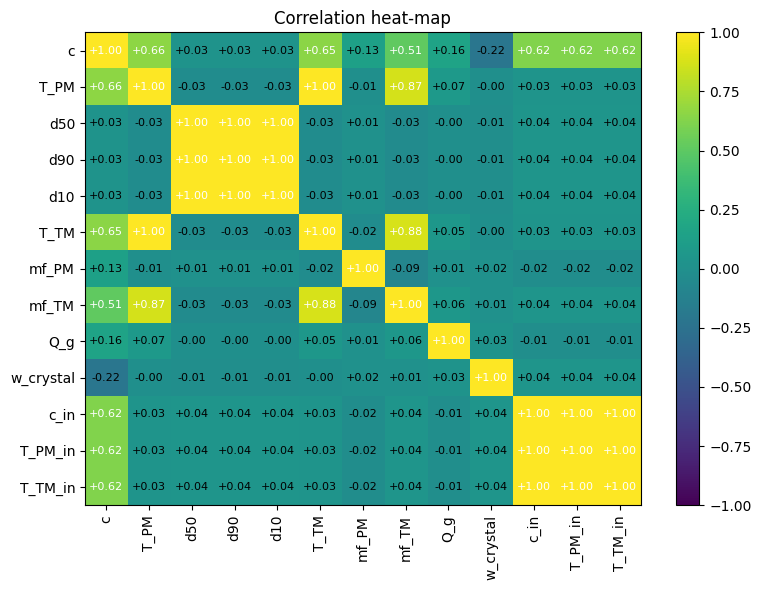

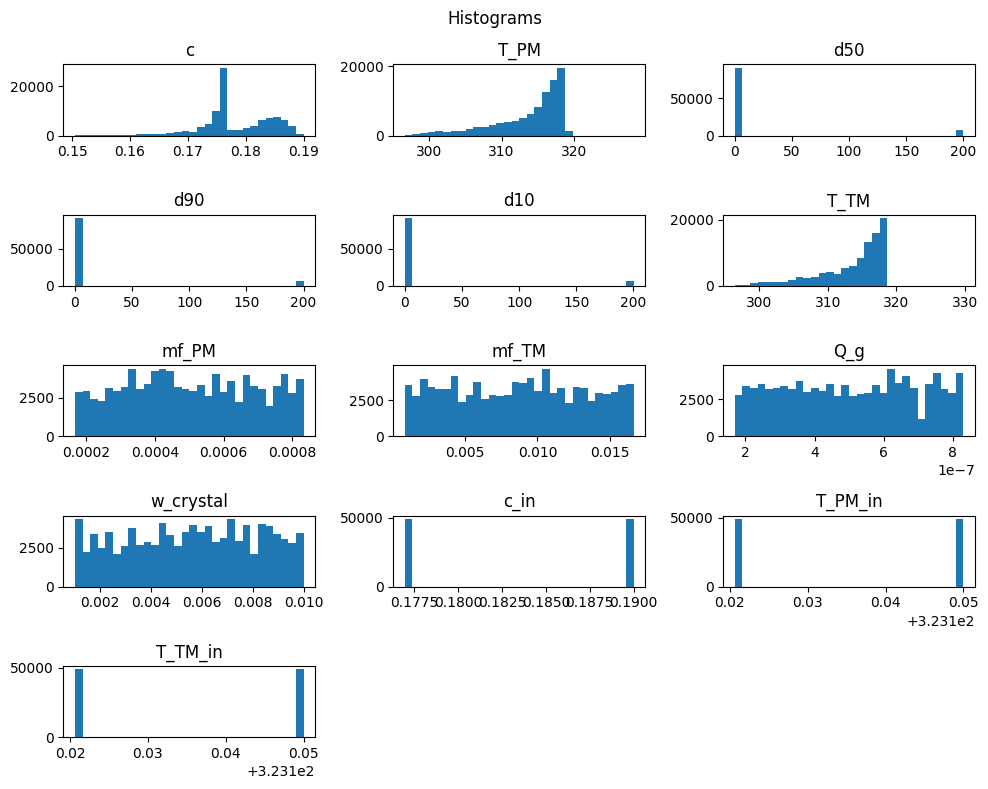

Dropped 3 highly correlated feature(s): ['T_TM', 'T_PM_in', 'T_TM_in']

Cleaned data preview:
          c        T_PM     mf_PM    mf_TM           Q_g  w_crystal     c_in  \
0  0.176778  318.716784  0.000665  0.01628  6.437788e-07   0.003225  0.17695   
1  0.176777  318.716784  0.000665  0.01628  6.437788e-07   0.003225  0.17695   
2  0.176776  318.716784  0.000665  0.01628  6.437788e-07   0.003225  0.17695   
3  0.176775  318.716784  0.000665  0.01628  6.437788e-07   0.003225  0.17695   
4  0.176778  318.716784  0.000665  0.01628  6.437788e-07   0.003225  0.17695   

       source    spread      skew  
0  file_14894  0.000076  0.235608  
1  file_14894  0.000144  1.077887  
2  file_14894  0.000169  2.928088  
3  file_14894  0.000055  0.260064  
4  file_14894  0.000057  0.439358  


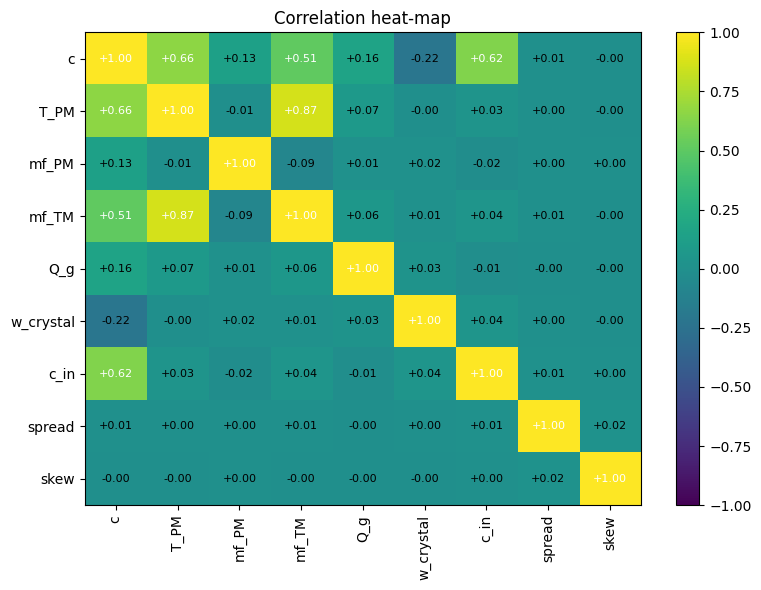

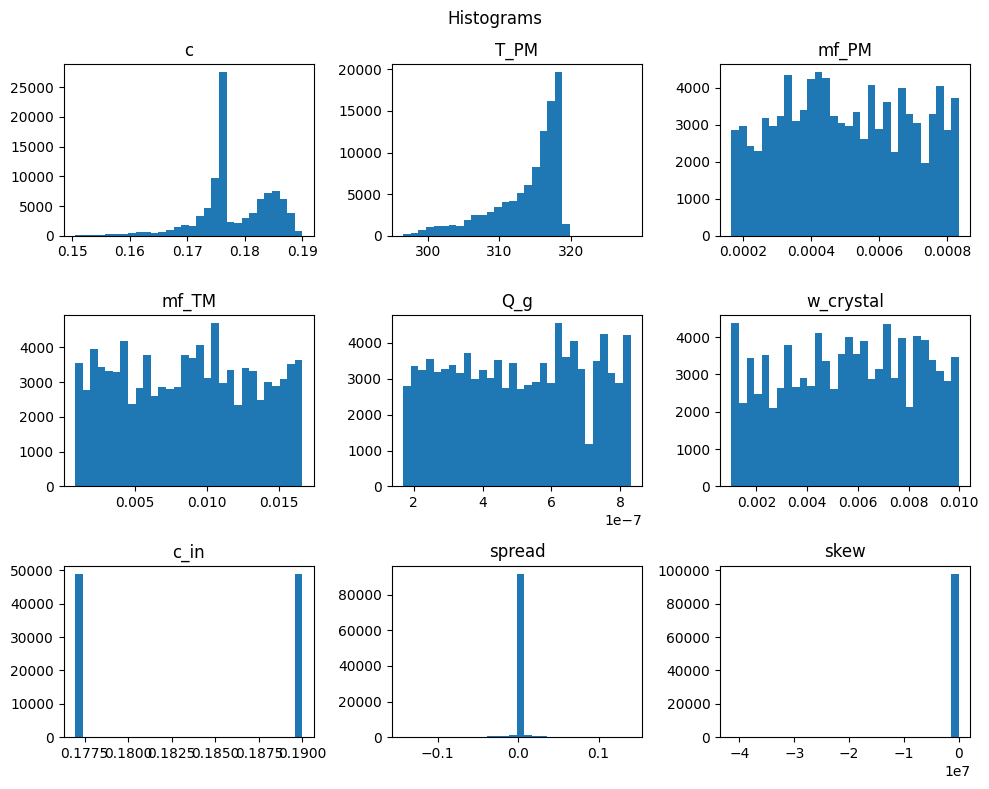

K=2, Silhouette Score=0.578
K=3, Silhouette Score=0.579
K=4, Silhouette Score=0.444
K=5, Silhouette Score=0.502
K=6, Silhouette Score=0.532


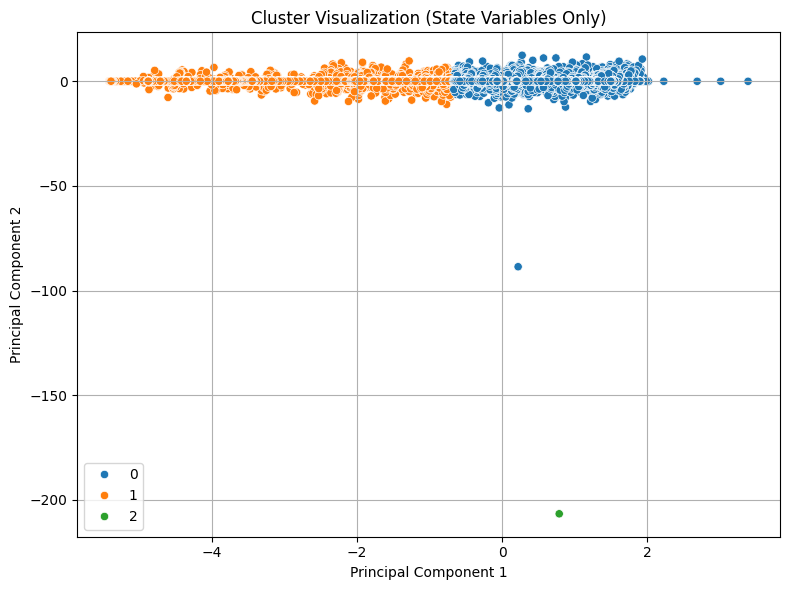

PermissionError: [Errno 13] Permission denied: 'clustered_output.csv'

In [1]:
"""
main.py — load, tidy and visualise data
---------------------------------------
Now shows plots *before* and *after* preprocessing.
"""

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import load_txt_folder     
from visualize import  visualize
from tidy import tidy_features   
from new_test import cluster_clean_data_states_only # your existing loader

def main() -> None:
    try:
        script_dir = Path(__file__).resolve().parent
    except NameError:
        script_dir = Path.cwd()

    data_dir = script_dir.parent / "Data"    

    df_raw = load_txt_folder(data_dir, sep="\t")        # ↪ raw

    print("\nRaw data preview:")
    print(df_raw.head())

    # ── 1️⃣  Visualise BEFORE preprocessing ─────────────────────────
    visualize(df_raw)

    # ── 2️⃣  Preprocess, then visualise AFTER ───────────────────────
    df_clean = tidy_features(df_raw, corr_thresh=0.95)

    print("\nCleaned data preview:")
    print(df_clean.head())

    visualize(df_clean)

    

    df_clustered = cluster_clean_data_states_only(df_clean)
    df_clustered.to_csv("clustered_output.csv", index=False)


if __name__ == "__main__":
    main()

    print(
        "\nWorkflow:\n"
        "  • Loads all text files in data_dir\n"
        "  • Visualises *raw* data (heat-map + histograms)\n"
        "  • Engineers spread & skew, drops high-corr features\n"
        "  • Visualises *clean* data\n"
        "\nAdjust paths, separators, or the correlation threshold as needed."
    )
